<a href="https://www.kaggle.com/code/yasinsoylu123/age-gender-cnn?scriptVersionId=97856132" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error



In [2]:
df = pd.read_csv('../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')

In [3]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


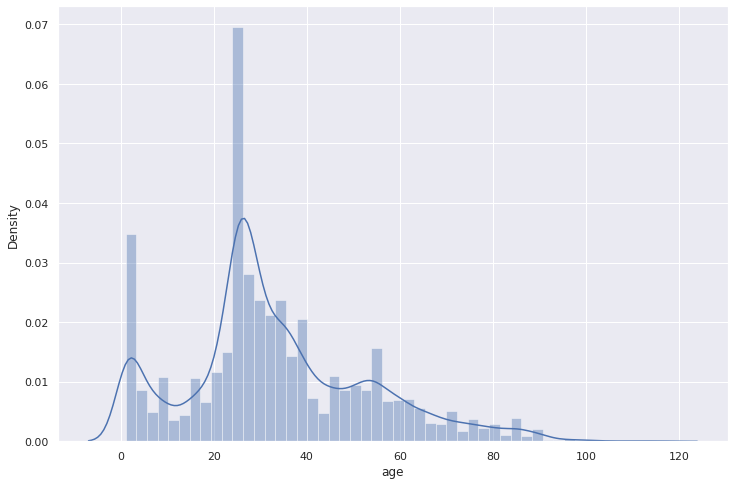

In [5]:
plt.figure(figsize=(12,8))
sns.distplot(df['age']);

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


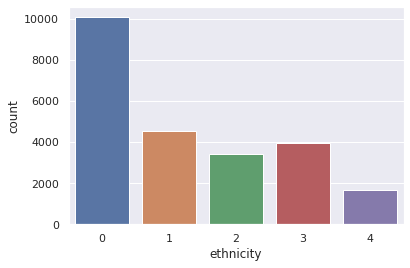

In [6]:
sns.countplot(df['ethnicity']);


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


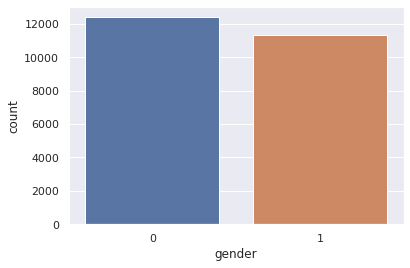

In [7]:
sns.countplot(df['gender']);


In [8]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

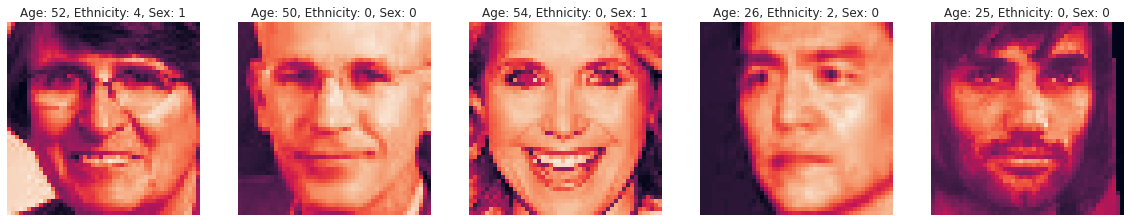

In [9]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face])
    axes[i].axis('off')

# Age prediction¶


In [10]:
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)

In [11]:
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255


In [12]:
input_shape = X_reshaped.shape[1:] 

In [13]:
y = df['age'].values


In [14]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [15]:
age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.5))
age_model.add(BatchNormalization())

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1))

age_model.compile(optimizer='adam', loss='mse')

age_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 128)       0

2022-06-09 00:31:19.030528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 00:31:19.150500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 00:31:19.151356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 00:31:19.153066: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
n_epochs = 50
batch_size = 64

In [17]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]             

In [18]:
history = age_model.fit(X_train, y_train, 
                        epochs=n_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

2022-06-09 00:31:22.283459: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-06-09 00:31:23.955382: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


297/297 [==============================] - 12s 15ms/step - loss: 245.2922 - val_loss: 3084.2588
Epoch 2/50
297/297 [==============================] - 4s 14ms/step - loss: 143.0091 - val_loss: 537.5262
Epoch 3/50
297/297 [==============================] - 4s 14ms/step - loss: 122.1115 - val_loss: 171.0421
Epoch 4/50
297/297 [==============================] - 4s 14ms/step - loss: 114.5781 - val_loss: 170.8308
Epoch 5/50
297/297 [==============================] - 4s 14ms/step - loss: 101.9863 - val_loss: 725.0328
Epoch 6/50
297/297 [==============================] - 4s 14ms/step - loss: 97.0866 - val_loss: 927.5687

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/50
297/297 [==============================] - 4s 14ms/step - loss: 80.8596 - val_loss: 74.2305
Epoch 8/50
297/297 [==============================] - 4s 14ms/step - loss: 76.1547 - val_loss: 68.7297
Epoch 9/50
297/297 [==============================] - 4s 14ms/step - loss: 73.8762 - val_los

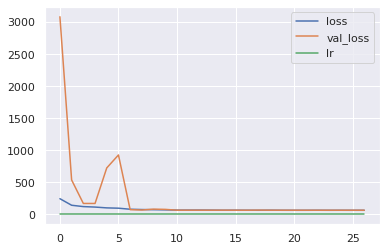

In [19]:
pd.DataFrame(history.history).plot();

In [20]:
valid_score = age_model.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 1s 4ms/step - loss: 65.2818


In [21]:
y_pred = age_model.predict(X_test)

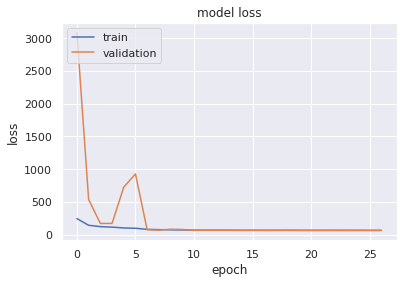

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.686436359294229



# Gender prediction¶


In [24]:
y = df['gender'].values
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [25]:
gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
#gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

gender_model.add(Flatten())

gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

gender_model.add(Dense(1, activation='sigmoid')) #For binary classification activation function is sigmoid 

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #...and loss function is binary_crossentropy

gender_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 10, 128)      

In [26]:
# Callbacks for gender model
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1)]

In [27]:
history = gender_model.fit(X_train, y_train, 
                           epochs=n_epochs,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

Epoch 1/50
297/297 [==============================] - 4s 11ms/step - loss: 0.5183 - accuracy: 0.7518 - val_loss: 1.3911 - val_accuracy: 0.5206
Epoch 2/50
297/297 [==============================] - 3s 9ms/step - loss: 0.3644 - accuracy: 0.8354 - val_loss: 0.3540 - val_accuracy: 0.8357
Epoch 3/50
297/297 [==============================] - 3s 9ms/step - loss: 0.3169 - accuracy: 0.8587 - val_loss: 0.2858 - val_accuracy: 0.8711
Epoch 4/50
297/297 [==============================] - 3s 10ms/step - loss: 0.2973 - accuracy: 0.8679 - val_loss: 0.3387 - val_accuracy: 0.8416
Epoch 5/50
297/297 [==============================] - 3s 9ms/step - loss: 0.2762 - accuracy: 0.8787 - val_loss: 0.3141 - val_accuracy: 0.8604

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/50
297/297 [==============================] - 3s 9ms/step - loss: 0.2425 - accuracy: 0.8951 - val_loss: 0.2469 - val_accuracy: 0.8935
Epoch 7/50
297/297 [==============================] - 3s 9ms/ste

In [28]:
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

149/149 [==============================] - 1s 4ms/step - loss: 0.2368 - accuracy: 0.9002
Accuracy for test set: 0.9002320170402527


In [29]:
y_pred = gender_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [30]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.89      0.90      2468
           1       0.88      0.92      0.90      2273

    accuracy                           0.90      4741
   macro avg       0.90      0.90      0.90      4741
weighted avg       0.90      0.90      0.90      4741



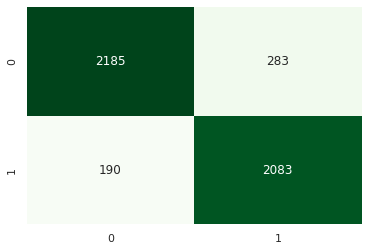

In [31]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');

In [32]:
y_pred = y_pred.reshape(y_pred.shape[0])


In [33]:
y = df['ethnicity'].values

y = to_categorical(y, 5)
y

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

# Ethnicity prediction


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=38)

In [35]:
eth_model = Sequential()

eth_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(Dropout(0.5))
eth_model.add(BatchNormalization())

eth_model.add(Flatten())
eth_model.add(Dense(128, activation='relu'))
eth_model.add(Dropout(0.5))
eth_model.add(Dense(5, activation='softmax')) 

eth_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

eth_model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7faa20f78890>>

In [36]:
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [37]:
history = eth_model.fit(X_train, y_train, 
                         epochs=n_epochs,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         validation_data=(X_test, y_test))

Epoch 1/50
297/297 [==============================] - 4s 10ms/step - loss: 1.1775 - accuracy: 0.5711 - val_loss: 4.0708 - val_accuracy: 0.4109
Epoch 2/50
297/297 [==============================] - 2s 8ms/step - loss: 0.9013 - accuracy: 0.6798 - val_loss: 1.1612 - val_accuracy: 0.5577
Epoch 3/50
297/297 [==============================] - 3s 9ms/step - loss: 0.8051 - accuracy: 0.7169 - val_loss: 0.7358 - val_accuracy: 0.7553
Epoch 4/50
297/297 [==============================] - 3s 9ms/step - loss: 0.7557 - accuracy: 0.7393 - val_loss: 0.7270 - val_accuracy: 0.7557
Epoch 5/50
297/297 [==============================] - 2s 8ms/step - loss: 0.6891 - accuracy: 0.7626 - val_loss: 1.2661 - val_accuracy: 0.4668
Epoch 6/50
297/297 [==============================] - 2s 8ms/step - loss: 0.6643 - accuracy: 0.7698 - val_loss: 0.7406 - val_accuracy: 0.7435

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/50
297/297 [==============================] - 2s 8ms/step

In [38]:
valid_score = eth_model.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 0s 3ms/step - loss: 0.5641 - accuracy: 0.8197


In [39]:
predictions = (eth_model.predict(X_test) > 0.5).astype("int32")
